### Metadata

In [1]:
%cd ..

/Users/davidrestrepo/Data Fusion/DF-DM


In [2]:
from src.Preprocessing.time_series_preprocessing import get_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor
from src.Preprocessing.time_series_preprocessing import read_static, read_features
from src.Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np
import random
import tensorflow as tf
import torch

def set_all_seeds(seed):
    """
    Set seed for reproducibility in different libraries.
    :param seed: An integer representing the seed value.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # Numpy library
    os.environ['PYTHONHASHSEED'] = str(seed)  # Environment variable

    # TensorFlow
    tf.random.set_seed(seed)
    if tf.__version__[0] == '2':
        # For TensorFlow 2.x, additionally set the global random seed
        tf.compat.v1.set_random_seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # If using GPU with PyTorch, set additional seeds
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU

In [3]:
DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
cohort = 'cities.csv'

In [4]:
cities = pd.read_csv(DIR_PATH + cohort)
cities

,lat,lng,Municipality,Municipality code,ISO
0,6.2447,-75.5748,Medellín,5001,CO-ANT
1,3.4400,-76.5197,Cali,76001,CO-VAC
2,4.5781,-74.2144,Soacha,25754,CO-CUN
3,4.1425,-73.6294,Villavicencio,50001,CO-MET
4,1.2136,-77.2811,Pasto,52001,CO-NAR
5,10.9639,-74.7964,Barranquilla,8001,CO-ATL
6,7.1186,-73.1161,Bucaramanga,68001,CO-SAN
7,4.4378,-75.2006,Ibagué,73001,CO-TOL
8,2.4411,-76.6061,Popayán,19001,CO-CAU
9,7.9075,-72.5047,Cúcuta,54001,CO-NSA


##### Constants

In [5]:
""" Read Dataset:"""
image_embeddings = 'Embeddings/Embeddings_dinov2_large.csv'
media_data = 'datasets/violence_prediction/internet_data.csv'
static = 'datasets/violence_prediction/metadata_labels.csv'

DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
labels = pd.read_csv(DIR_PATH + file)

# Get list of municipalities:
cohort = 'cities.csv'
cities = pd.read_csv(DIR_PATH + cohort)
Municipalities = cities.Municipality.values

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

seed = 1
n_tests = 3

### Read and Preprocess the Data

#### Read the Data

In [6]:
# Read dataset
dengue_df = [get_dataset(labels_path=labels, embeddings_path=image_embeddings, municipality=Municipality, temp_prec=media_data, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of Medellín only...
Obtaining dataframe for the city of Medellín only...
Obtaining dataframe for the city of Cali only...
Obtaining dataframe for the city of Cali only...
Obtaining dataframe for the city of Soacha only...
Obtaining dataframe for the city of Soacha only...
Obtaining dataframe for the city of Villavicencio only...
Obtaining dataframe for the city of Villavicencio only...
Obtaining dataframe for the city of Pasto only...
Obtaining dataframe for the city of Pasto only...
Obtaining dataframe for the city of Barranquilla only...
Obtaining dataframe for the city of Barranquilla only...
Obtaining dataframe for the city of Bucaramanga only...
Obtaining dataframe for the city of Bucaramanga only...
Obtaining dataframe for the city of Ibagué only...
Obtaining dataframe for the city of Ibagué only...
Obtaining dataframe for the city of Popayán only...
Obtaining dataframe for the city of Popayán only...
Obtaining dataframe for the city of Cúcuta onl

list

#### Train-Test Split

In [7]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
    

The train shape is: (187, 1058)
The test shape is: (47, 1058)
The train shape is: (145, 1058)
The test shape is: (37, 1058)
The train shape is: (206, 1058)
The test shape is: (52, 1058)
The train shape is: (32, 1058)
The test shape is: (8, 1058)
The train shape is: (131, 1058)
The test shape is: (33, 1058)
The train shape is: (150, 1058)
The test shape is: (38, 1058)
The train shape is: (112, 1058)
The test shape is: (28, 1058)
The train shape is: (80, 1058)
The test shape is: (20, 1058)
The train shape is: (80, 1058)
The test shape is: (21, 1058)
The train shape is: (127, 1058)
The test shape is: (32, 1058)


#### Normalize the Data

In [8]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [9]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

train_df[1].head()

0         1         2         3         4         5  \
Cali 201801 -0.194073  0.744625  0.079814  0.327304 -0.160235 -1.004795   
     201802 -0.194073  0.744625  0.079814  0.327304 -0.160235 -1.004795   
     201803 -0.032527 -0.183724 -0.220589  0.298857  0.460228 -0.269544   
     201804 -1.229488  0.086381 -0.588294  0.012353  0.155760  0.329343   
     201805  1.891563 -0.487735 -1.386612 -1.190906 -0.149988  0.244468   

                    6         7         8         9  ...  \
Cali 201801 -0.756570  0.091899 -1.058797  1.030953  ...   
     201802 -0.756570  0.091899 -1.058797  1.030953  ...   
     201803  0.661721  1.185059 -1.513767  0.618451  ...   
     201804  0.031748  0.753130  0.374352  1.112663  ...   
     201805  0.357758 -2.166119  1.280621 -2.775639  ...   

             Buildingstratification1(%)  Buildingstratification2(%)  \
Cali 201801                    -0.58877                   -0.495713   
     201802                    -0.58877                   -0.495713   
     201803                    -0.58877                   -0.495713   
     201804                    -0.58877                   -0.495713   
     201805                    -0.58877                   -0.495713   

             Buildingstratification3(%)  Buildingstratification4(%)  \
Cali 201801                    0.484871                    0.219844   
     201802                    0.484871                    0.219844   
     201803                    0.484871                    0.219844   
     201804                    0.484871                    0.219844   
     201805                    0.484871                    0.219844   

             Buildingstratification5(%)  Buildingstratification6(%)  \
Cali 201801                    1.553038                    0.486149   
     201802                    1.553038                    0.486149   
     201803                    1.553038                    0.486149   
     201804                    1.553038                    0.486149   
     201805                    1.553038                    0.486149   

             NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
Cali 201801                 -0.01718              0.130085    1.430892   
     201802                 -0.01718              0.130085    1.430892   
     201803                 -0.01718              0.130085    1.430892   
     201804                 -0.01718              0.130085    1.430892   
     201805                 -0.01718              0.130085    1.430892   

               Labels  
Cali 201801  0.426469  
     201802 -0.023963  
     201803  0.253226  
     201804  0.807604  
     201805  0.339848  

[5 rows x 1058 columns]

In [10]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
Cali 202135  0.025028  1.316759  1.046841  0.696690 -0.226093 -1.245519   
     202138  2.580524 -0.329206 -0.871342 -0.038902 -0.563601 -0.814378   
     202146  0.225738 -0.743871 -1.111945  0.083912  0.404325  0.131537   
     202147 -0.941087  0.116581 -0.009232 -0.115662 -0.143917  0.570095   
     202148 -0.289620  0.724936 -0.081738  0.214731  0.321948 -0.644681   

                    6         7         8         9  ...  \
Cali 202135 -0.719722 -0.173901 -1.269728  1.373508  ...   
     202138 -1.034712 -2.084810  0.148727 -0.136880  ...   
     202146  0.344659 -0.213428  0.861666 -1.445449  ...   
     202147  0.757805  1.554196  0.127458  0.682547  ...   
     202148  0.468333  1.166496 -1.024629  0.915005  ...   

             Buildingstratification1(%)  Buildingstratification2(%)  \
Cali 202135                    -0.58877                   -0.495713   
     202138                    -0.58877                   -0.495713   
     202146                    -0.58877                   -0.495713   
     202147                    -0.58877                   -0.495713   
     202148                    -0.58877                   -0.495713   

             Buildingstratification3(%)  Buildingstratification4(%)  \
Cali 202135                    0.484871                    0.219844   
     202138                    0.484871                    0.219844   
     202146                    0.484871                    0.219844   
     202147                    0.484871                    0.219844   
     202148                    0.484871                    0.219844   

             Buildingstratification5(%)  Buildingstratification6(%)  \
Cali 202135                    1.553038                    0.486149   
     202138                    1.553038                    0.486149   
     202146                    1.553038                    0.486149   
     202147                    1.553038                    0.486149   
     202148                    1.553038                    0.486149   

             NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
Cali 202135                 -0.01718              0.130085    1.430892   
     202138                 -0.01718              0.130085    1.430892   
     202146                 -0.01718              0.130085    1.430892   
     202147                 -0.01718              0.130085    1.430892   
     202148                 -0.01718              0.130085    1.430892   

               Labels  
Cali 202135  0.928875  
     202138  1.396631  
     202146  0.582388  
     202147  0.824929  
     202148  0.183929  

[5 rows x 1058 columns]

#### Prepare data for time series supervised learning (function to create sliding window)

In [11]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(143, 3172)

#### Merge

In [12]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

train.shape

(1230, 3172)

#### Features and Labels Set

In [13]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1230, 3171)
The shape of the labels is (1230, 1)
Test:
The shape of the features is (296, 3171)
The shape of the labels is (296, 1)


In [14]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1230, 3171)
The test shape is (296, 3171)
-----------------------
The Final shapes are:
The train shape is (1230, 3, 1057)
The test shape is (296, 3, 1057)


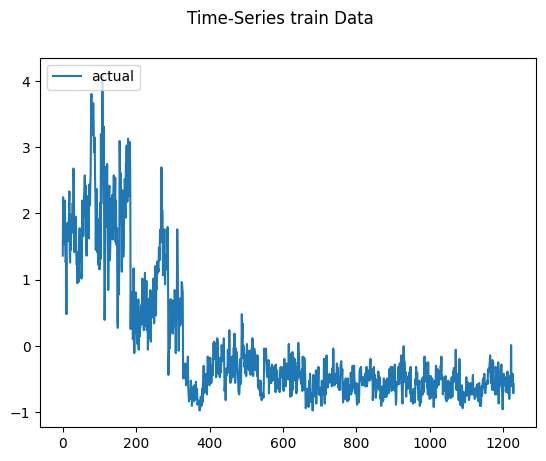

2024-01-17 01:51:26.004964: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-17 01:51:26.005071: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-17 01:51:26.005128: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-17 01:51:26.010263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 01:51:26.011750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-17 01:51:29.680622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:51:30.264154: I te

Restoring model weights from the end of the best epoch: 10.
Epoch 18: early stopping


2024-01-17 01:53:22.538217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:53:22.712785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 8/10 [=======================>......] - ETA: 0s

2024-01-17 01:53:22.791659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 20ms/step
Test MAE: 30.478
Test RMSE: 40.044
Test sMAPE: 46.578
Test R Squared: 0.406
{'mae': 30.47755907032941, 'rmse': 40.043780622482494, 'smape': 46.578111452438904, 'r2': 0.4058629614809002}


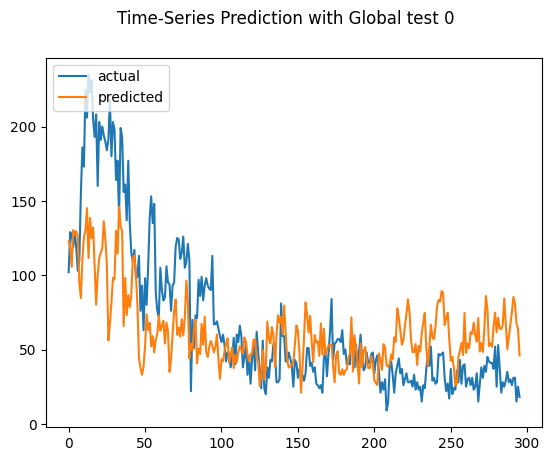

2024-01-17 01:53:26.135889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:53:26.686759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:53:26.806483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:53:27.240055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:53:27.393252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:53:34.193309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:53:34.396222: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 12.
Epoch 20: early stopping


2024-01-17 01:55:15.226996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:55:15.412679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/10 [==============>...............] - ETA: 0s

2024-01-17 01:55:15.498803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 26ms/step
Test MAE: 29.870
Test RMSE: 40.345
Test sMAPE: 45.498
Test R Squared: 0.397
{'mae': 29.86986958658373, 'rmse': 40.345220145890664, 'smape': 45.497840975366266, 'r2': 0.39688426470245486}


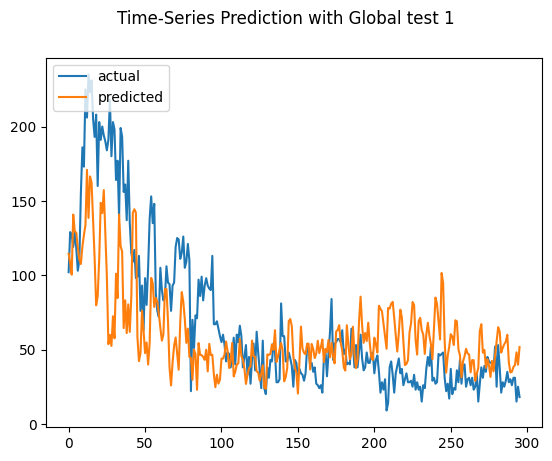

2024-01-17 01:55:19.077001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:55:19.657063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:55:19.766631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:55:20.341163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:55:20.548873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:55:31.077915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:55:31.311988: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 14.
Epoch 22: early stopping


2024-01-17 01:57:23.150767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:57:23.341364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 10s

2024-01-17 01:57:23.630260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 23ms/step
Test MAE: 31.067
Test RMSE: 42.897
Test sMAPE: 45.742
Test R Squared: 0.318
{'mae': 31.067332441742355, 'rmse': 42.896533022610136, 'smape': 45.74201039081445, 'r2': 0.31819392509670175}


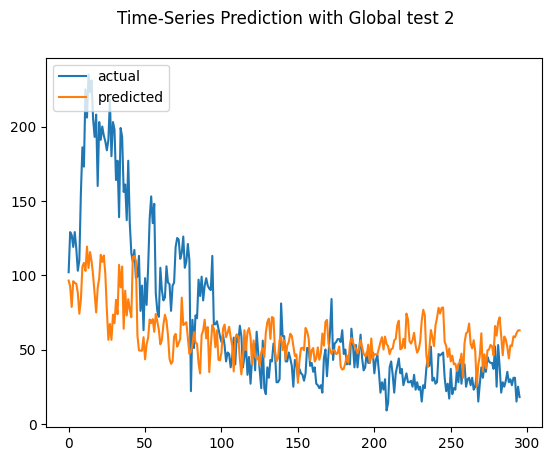

rmse : average=41.095, std=1.280
mae : average=30.472, std=0.489
smape : average=45.939, std=0.463
r2 : average=0.374, std=0.039


([41.095177930327765, 1.2796813595414702],
 [30.471587032885164, 0.48888040207163747],
 [45.93932093953987, 0.46256146646503965],
 [0.37364705042668556, 0.0393822386413553])

In [15]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

set_all_seeds(1)
calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global')

### Late Fusion Model

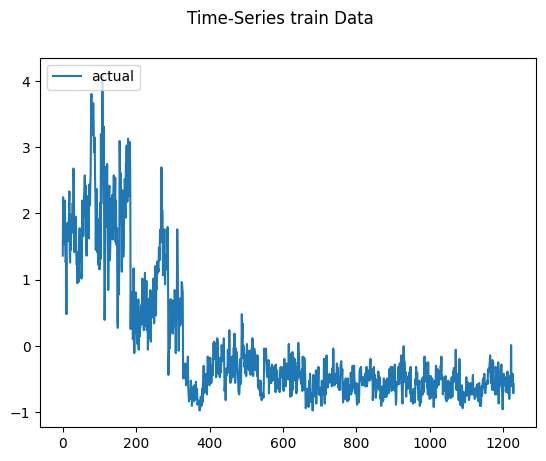

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 3, 1000)           8176000   
                                                                 
 lstm_7 (LSTM)               (None, 500)               3002000   
                                                                 
 batch_normalization_9 (Bat  (None, 500)               2000      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 250)               125250    
                                                                 
 batch_normalization_10 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 120)              

2024-01-17 02:13:04.464039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:13:06.105190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:13:06.109948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:13:06.111763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:13:06.115504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:13:06.761588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:13:06.763872: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 11.
Epoch 19: early stopping
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_6_input (InputLayer)   [(None, 3, 1043)]            0         []                            
                                                                                                  
 lstm_8_input (InputLayer)   [(None, 3, 7)]               0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 120)                  1133685   ['lstm_6_input[0][0]']        
                                                          0                                       
                                                                                                  
 sequenti

2024-01-17 02:16:03.770236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:04.649815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:04.650311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:04.683502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:04.683524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:05.314409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:05.316745: I tensorflow/core/grappler/optimizers/cust

10/10 [==============================] - 9s 166ms/step
Test MAE: 26.590
Test RMSE: 35.462
Test sMAPE: 53.097
Test R Squared: 0.534
{'mae': 26.58955394675502, 'rmse': 35.46161893550857, 'smape': 53.09704510290124, 'r2': 0.5340561353252687}


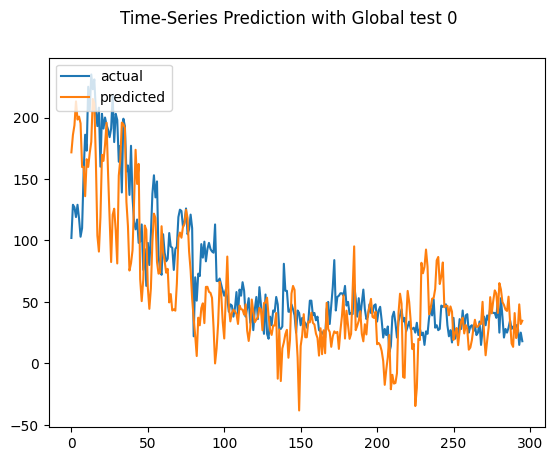

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 3, 1000)           8176000   
                                                                 
 lstm_11 (LSTM)              (None, 500)               3002000   
                                                                 
 batch_normalization_15 (Ba  (None, 500)               2000      
 tchNormalization)                                               
                                                                 
 dense_21 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_16 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 120)              

2024-01-17 02:16:28.233020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:29.627665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:29.629354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:29.650450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:29.650517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:30.353525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:16:30.401782: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 21.
Epoch 29: early stopping
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_10_input (InputLayer)  [(None, 3, 1043)]            0         []                            
                                                                                                  
 lstm_12_input (InputLayer)  [(None, 3, 7)]               0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 120)                  1133685   ['lstm_10_input[0][0]']       
                                                          0                                       
                                                                                                  
 sequen

2024-01-17 02:20:04.693440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:05.443896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:05.468963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:05.678712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:05.714043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:05.731182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:05.975716: I tensorflow/core/grappler/optimizers/cust

10/10 [==============================] - 5s 126ms/step
Test MAE: 33.979
Test RMSE: 44.857
Test sMAPE: 82.720
Test R Squared: 0.254
{'mae': 33.97890988893404, 'rmse': 44.85747344468688, 'smape': 82.72043700545488, 'r2': 0.25443399491428176}


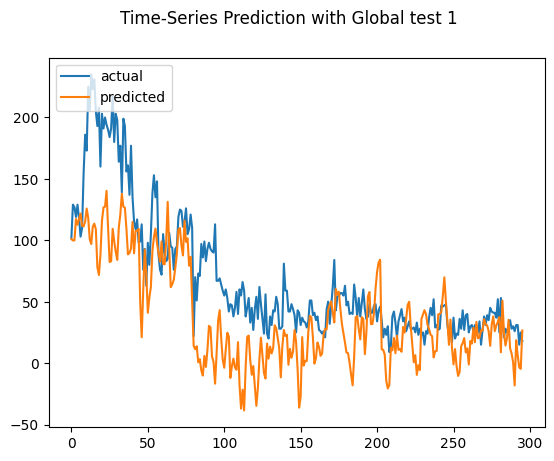

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 3, 1000)           8176000   
                                                                 
 lstm_15 (LSTM)              (None, 500)               3002000   
                                                                 
 batch_normalization_21 (Ba  (None, 500)               2000      
 tchNormalization)                                               
                                                                 
 dense_33 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_22 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 120)             

2024-01-17 02:20:29.744875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:31.818179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:31.825624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:31.859206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:31.874374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:33.084250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:20:33.133982: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 14.
Epoch 22: early stopping
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_14_input (InputLayer)  [(None, 3, 1043)]            0         []                            
                                                                                                  
 lstm_16_input (InputLayer)  [(None, 3, 7)]               0         []                            
                                                                                                  
 sequential_13 (Sequential)  (None, 120)                  1133685   ['lstm_14_input[0][0]']       
                                                          0                                       
                                                                                                  
 sequen

2024-01-17 02:23:35.748121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:23:36.701022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:23:36.701076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:23:36.727696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:23:36.731484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:23:37.441417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 02:23:37.459156: I tensorflow/core/grappler/optimizers/cust

10/10 [==============================] - 21s 210ms/step
Test MAE: 25.611
Test RMSE: 33.813
Test sMAPE: 43.744
Test R Squared: 0.576
{'mae': 25.610993374038387, 'rmse': 33.81275751828818, 'smape': 43.74362503877637, 'r2': 0.5763788251324238}


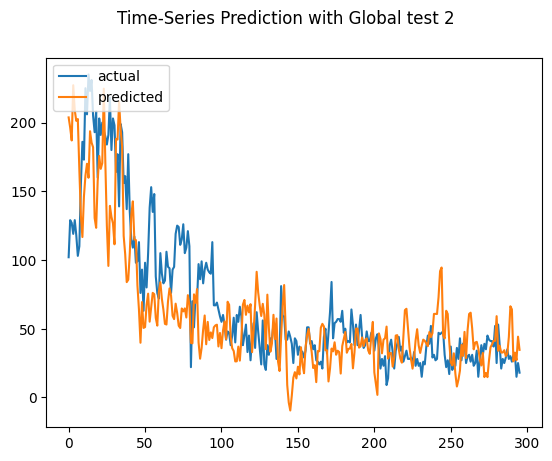

rmse : average=38.044, std=4.865
mae : average=28.726, std=3.735
smape : average=59.854, std=16.614
r2 : average=0.455, std=0.143


([38.043949966161215, 4.864686535815364],
 [28.726485736575814, 3.7354486393493964],
 [59.8537023823775, 16.61399572580656],
 [0.4549563184573248, 0.1428395468056233])

In [17]:
set_all_seeds(1)

x_ar = train_X[:, :, :7]
x_ar_test = test_X[:, :, :7]
train_X = train_X[:, :, 7:]
test_X = test_X[:, :, 7:]

calculate_mean_std(lstm_layers, nn_layers, sequence, train_X.shape[2], dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion='joint', x_ar=x_ar, x_ar_test=x_ar_test)